# Tutorial on metasyn-disclosure

In this tutorial, we will show how to use the metasyn disclosure control plugin to enhance the privacy of generative metadata (MetaFrames and exported GMF files). 

This tutorial assumes you are familiar with the basic workflow of `metasyn`,  if you're not, please first check out our [metasyn tutorials](https://metasynth.readthedocs.io/en/latest/usage/interactive_tutorials.html).

## Setup

### Installation
The first step is to install the metasyn-disclosure package, this can be done by uncommenting the following line and running it.

In [43]:
# !pip install git+https://github.com/sodascience/metasyn-disclosure-control.git

### Importing Packages
Then we import the necessary packages.

In [44]:
import polars as pl
from metasyn import MetaFrame, demo_dataframe
from metasyn.distribution import (
    DiscreteUniformDistribution,
    FakerDistribution,
    RegexDistribution,
)

from metasyncontrib.disclosure import DisclosurePrivacy

### Loading the dataset

The first step in creating the metadata is reading and converting your dataset to a polars DataFrame. For this tutorial, we will use the demo DataFrame provided by metasyn.  

In [45]:
df = demo_dataframe('titanic') # preconfigured Polars DataFrame based on the Titanic dataset
df.head()

PassengerId,Name,Sex,Age,Parch,Ticket,Fare,Cabin,Embarked,Birthday,Board time,Married since,all_NA
i64,str,cat,i64,i64,str,f64,str,cat,date,time,datetime[μs],str
1,"""Braund, Mr. Owen Harris""","""male""",22,0,"""A/5 21171""",7.25,null,"""S""",1937-10-28,15:53:04,2022-08-05 04:43:34,null
2,"""Cumings, Mrs. John Bradley (Fl…","""female""",38,0,"""PC 17599""",71.2833,"""C85""","""C""",null,12:26:00,2022-08-07 01:56:33,null
3,"""Heikkinen, Miss. Laina""","""female""",26,0,"""STON/O2. 3101282""",7.925,null,"""S""",1931-09-24,16:08:25,2022-08-04 20:27:37,null
4,"""Futrelle, Mrs. Jacques Heath (…","""female""",35,0,"""113803""",53.1,"""C123""","""S""",1936-11-30,null,2022-08-07 07:05:55,null
5,"""Allen, Mr. William Henry""","""male""",35,0,"""373450""",8.05,null,"""S""",1918-11-07,10:59:08,2022-08-02 15:13:34,null


## Using Disclosure Control

First, let's look at what happens when we fit a MetaFrame to the data without the disclosure plugin.

### Without Disclosure Control

In [46]:
mf = MetaFrame.fit_dataframe(
    df=df,
)

print(
    f"Original Data vs Generative MetaData (for 'Married since' column):\n"
    f"Range in Source DataFrame: {df['Married since'].min()} - {df['Married since'].max()}\n"
    f"Range in Fitted MetaFrame: {mf['Married since'].distribution.lower} - {mf['Married since'].distribution.upper}"
)

  0%|          | 0/13 [00:00<?, ?it/s]/Users/samuel/Desktop/Creating/Python Projects/AIGT/env/lib/python3.11/site-packages/metasyn/provider.py:288: UserWarning: 
Variable 'PassengerId' was detected to be unique, but has not explicitly been set to unique.
To generate only unique values for column 'PassengerId', set unique to True.
To dismiss this warning, set unique to False.
  warnings.warn(
100%|██████████| 13/13 [00:01<00:00, 12.58it/s]

Original Data vs Generative MetaData (for 'Married since' column):
Range in Source DataFrame: 2022-07-15 12:21:15 - 2022-08-15 10:32:05
Range in Fitted MetaFrame: 2022-07-15 12:21:15 - 2022-08-15 10:32:05


As you can see, when comparing the original data to the fitted MetaFrame, we can see that the lower bound of the distribution is equal to the lowest value in the source DataFrame, and the upper bound is equal to the highest value. 

This means that source data can be easily inferred from the generative metadata.


### With Disclosure Control

By using the disclosure plugin, we can prevent this privacy concern. 

We can opt to use the disclosure plugin for the entire MetaFrame, by setting the `privacy` parameter to `DisclosurePrivacy()` when fitting the MetaFrame. 

In [47]:
mf_disclosure = MetaFrame.fit_dataframe(
    df=df,
    privacy=DisclosurePrivacy(),  # Make the entire MetaFrame use disclosure control
)

print(
    f"Original Data vs Generative MetaData (for 'Married since' column):\n"
    f"Range in Source DataFrame: {df['Married since'].min()} - {df['Married since'].max()}\n"
    f"Range in Fitted MetaFrame: {mf_disclosure['Married since'].distribution.lower} - {mf_disclosure['Married since'].distribution.upper}"
)

100%|██████████| 13/13 [00:00<00:00, 24.87it/s]

Original Data vs Generative MetaData (for 'Married since' column):
Range in Source DataFrame: 2022-07-15 12:21:15 - 2022-08-15 10:32:05
Range in Fitted MetaFrame: 2022-07-15 17:12:24 - 2022-08-15 07:56:54


As you can see, the disclosure plugin fixes the privacy concern present in the base metasyn package: distribution bounds are no longer equal to the source data. 

### Manually Specifying Distributions
However, there still is a problem. The disclosure plugin does not implement every type of distribution that the base metasyn package does. This means, that in cases where a distribution can not be found, the plugin will default to a NA distribution (returning only NA values).
We can see this happening if we print the generative metadata, for example, notice how the 'Cabin' column has a NA distribution.

In [48]:
print(mf_disclosure["Cabin"])

"Cabin"
- Variable Type: string
- Data Type: String
- Proportion of Missing Values: 0.7710
- Distribution:
	- Type: core.na
	- Provenance: metasyn-disclosure
	- Parameters:
	
	



We can fix this by manually specifying the distributions for the variables that the disclosure plugin does not support. For example, we can set the 'Cabin' column to have a regex distribution.

In [49]:
specs = [
    # Specify cabin to have a RegexDistribution
    {"name": "Cabin", "distribution": RegexDistribution(r"[ABCDEF][0-9]{2,3}")},
]

mf_disclosure = MetaFrame.fit_dataframe(
    df=df,
    var_specs=specs, 
    privacy=DisclosurePrivacy(),  
)

print(mf_disclosure["Cabin"])


100%|██████████| 13/13 [00:00<00:00, 33.97it/s]

"Cabin"
- Variable Type: string
- Data Type: String
- Proportion of Missing Values: 0.7710
- Distribution:
	- Type: core.regex
	- Provenance: builtin
	- Parameters:
		- regex: [ABCDEF][0-9]{2,3}
	



As you can see, the 'Cabin' column now has a RegexDistribution, and is no longer NA.

## Privacy Control for Individual Columns

Instead of using disclosure control for the entire MetaFrame, we can also use it for individual columns.  This way, other columns (which might not be supported by the disclosure plugin) can still use the base metasyn distributions.

To do so, we have to specify the `privacy` parameter for the variable in the variable specification.

We can do this as follows:

In [50]:
specs_disclosure = [
    # Use disclosure control for the 'Married since' column
    {"name": "Married since", "privacy": DisclosurePrivacy()}
]

Then, when fitting the MetaFrame, we have to specify the `dist_providers` parameter to include both the "builtin" distributions, as well as the diclosure variations. 
We have to include them both because otherwise the distributions not specified in the var_spec to use the disclosure plugin will give an error. 

In [51]:
mf_disclosure_alt = MetaFrame.fit_dataframe(
    df=df,
    var_specs=specs_disclosure,
)

print(
    f"Original Data vs Generative MetaData (for 'Married since' column):\n"
    f"Range in Source DataFrame: {df['Married since'].min()} - {df['Married since'].max()}\n"
    f"Range in Fitted MetaFrame: {mf_disclosure_alt['Married since'].distribution.lower} - {mf_disclosure_alt['Married since'].distribution.upper}"
)

mf_disclosure_alt.synthesize(5)

100%|██████████| 13/13 [00:00<00:00, 13.13it/s]

Original Data vs Generative MetaData (for 'Married since' column):
Range in Source DataFrame: 2022-07-15 12:21:15 - 2022-08-15 10:32:05
Range in Fitted MetaFrame: 2022-07-15 17:12:24 - 2022-08-15 07:56:54


PassengerId,Name,Sex,Age,Parch,Ticket,Fare,Cabin,Embarked,Birthday,Board time,Married since,all_NA
i64,str,cat,i64,i64,str,f64,str,cat,date,time,datetime[μs],null
133,"""Painting expert very ask. Mana…","""female""",null,1,"""920570""",9.440269,null,"""C""",1938-10-08,14:19:42,2022-08-07 13:48:39,null
287,"""Fall suggest be station. Daugh…","""female""",22,0,"""149436""",18.1133,"""F5""","""S""",1938-02-17,null,2022-07-24 02:19:45,null
838,"""New. Avoid. White.""","""male""",24,0,"""1796""",52.68039,null,"""C""",1904-02-23,14:50:36,2022-07-18 09:56:16,null
486,"""College mind future doctor. Ch…","""male""",59,0,"""06671""",21.144295,null,"""Q""",1922-10-03,18:06:25,2022-07-23 19:46:49,null
508,"""Threat debate. Wrong current w…","""male""",null,0,"""759178""",43.758727,"""D267""","""S""",1909-09-04,17:11:46,2022-08-13 08:55:29,null


As you can see by the bounds, the disclosure plugin has been applied effectively for the 'Married since' column.

## Changing the Privacy Level

By default, the disclosure privacy partition size is set to 11.  This partition size determines how data is grouped for privacy protection. Data is grouped into partitions of (at least) the specified size, and the mean of each group is then used. A larger partition size increases privacy but may reduce data utility, while a smaller partition size may increase utility but decrease privacy.

The partition size can be changed by specifying the `partition_size` parameter in the `DisclosurePrivacy` class. This can be done either for the entire MetaFrame, or for individual columns.

When using the plugin for the entire MetaFrame, the syntax is as follows:

In [52]:
mf = MetaFrame.fit_dataframe(
    df=df,
    privacy=DisclosurePrivacy(partition_size=20),  # Set the partition size to 20
)

100%|██████████| 13/13 [00:00<00:00, 26.79it/s]


When using the plugin for individual columns, the syntax is as follows:

In [53]:
specs = [
    {"name": "Married since", "privacy": DisclosurePrivacy(partition_size=20)},
]

mf = MetaFrame.fit_dataframe(
    df=df,
    var_specs=specs,
)

100%|██████████| 13/13 [00:01<00:00, 10.70it/s]


Below, you can see how a larger partition size affects the generative metadata (and the generated data). 

Here we plot the effect of the partition size on the 'Age' column, comparing the original data, to the generative metadata with the default (11) partition size, and the generative metadata with an extremely large (250) partition size.

You can see that the small partition size still follows a similar distribution to the original data, while the large partition size has a very smoothed out distribution (due to averaging larger groups of data).

  0%|          | 0/13 [00:00<?, ?it/s]/Users/samuel/Desktop/Creating/Python Projects/AIGT/env/lib/python3.11/site-packages/metasyn/provider.py:288: UserWarning: 
Variable 'PassengerId' was detected to be unique, but has not explicitly been set to unique.
To generate only unique values for column 'PassengerId', set unique to True.
To dismiss this warning, set unique to False.
  warnings.warn(
100%|██████████| 13/13 [00:00<00:00, 34.19it/s]


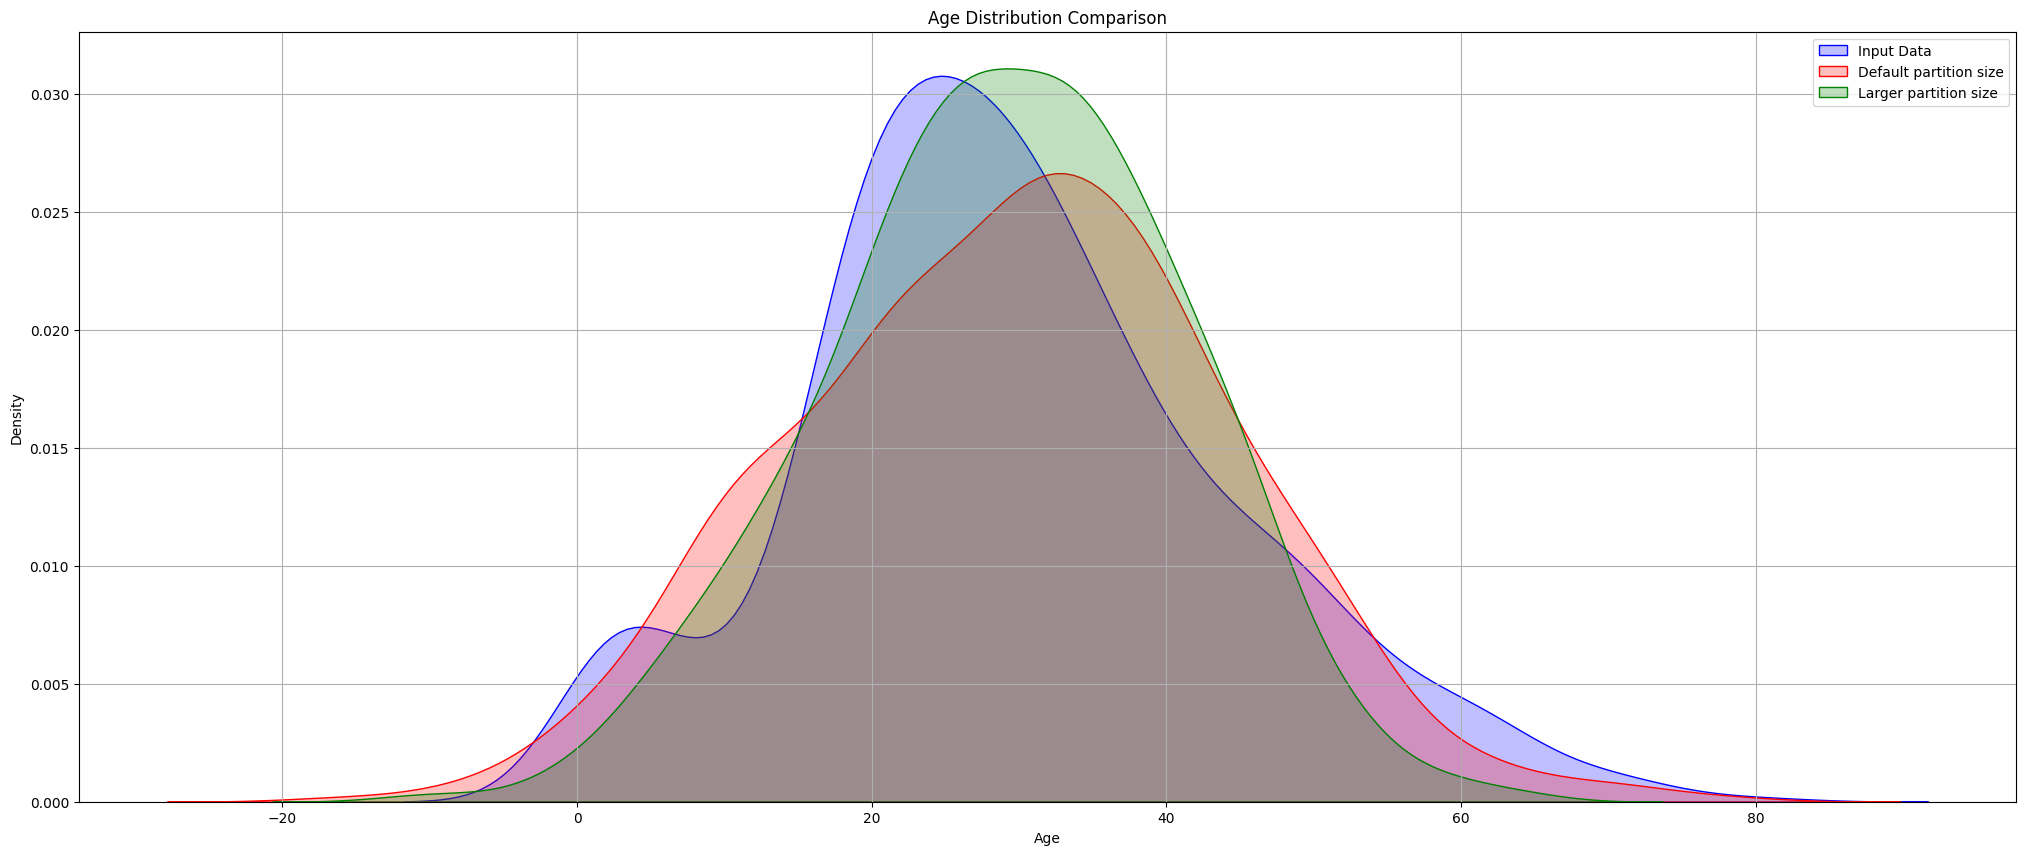

In [55]:
import seaborn as sns

# Fit metaframes
mf_default = MetaFrame.fit_dataframe(
    df=df,
    privacy=DisclosurePrivacy(),  # Default partition size of 11
)

mf_large = MetaFrame.fit_dataframe(
    df=df,
    privacy=DisclosurePrivacy(partition_size=250),  # Larger partition size
)

# Generate synthetic data
synthetic_data_default = mf_default.synthesize()
synthetic_data_large = mf_large.synthesize()

# Compare the age column
plt.figure(figsize=(25, 10))

# Add plots
sns.kdeplot(df['Age'], color='blue', fill=True, label='Input Data')
sns.kdeplot(synthetic_data_default['Age'], color='red', fill=True, label='Default partition size')
sns.kdeplot(synthetic_data_large['Age'], color='green', fill=True, label='Larger partition size')

# Adding labels and formatting
plt.legend(loc='upper right')
plt.title('Age Distribution Comparison')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(True)

plt.show()

# Conclusion
That covers the basics of using the disclosure control plugin. If you have any questions, or encounter an issue, please feel free to reach out to us on our [GitHub page](https://github.com/sodascience/metasyn-disclosure-control)